In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
#There are many geocoding services available, but Nominatim does not require an API key to access.
from geopy.geocoders import Nominatim
import folium #Interracting map
from matplotlib import pyplot
from matplotlib.pyplot import figure

## Data Exploration
- Let's extract the data first and concat the two json file into single csv file. Save the csv file
- Data exploration afterwards

In [2]:
# df = pd.read_json('gumtree.json')
# df2 = pd.read_json('remaininggumtree.json')
# data = pd.concat([df,df2])
# #Saving it as a final_data.csv
# data.to_csv('final_data.csv',index=False)

In [3]:
dataset = pd.read_csv('finals.csv')

In [4]:
#Let's check out the coloumn names
dataset.columns #All the coloumns here are important so we won't be deleting it. 

Index(['Unnamed: 0', 'Year', 'Body type', 'Mileage', 'Transmission',
       'Brochure Engine size', 'Fuel type', 'Urban mpg', 'Extra Urban mpg',
       'Fuel Consumption', 'Insurance Group', 'CO2 emissions',
       'Euro Emissions', 'Engine Power', 'Engine size',
       'Acceleration (0-62mph)', 'Top Speed', 'Seats', 'Doors', 'Colour',
       'Fuel Capacity', 'Luggage Capacity (seats up)', 'Price', 'Name',
       'Location'],
      dtype='object')

In [5]:
#However some of the coloumns needs some renaming to be done 
#The reason we are doing this is because we want
dataset.rename({'Acceleration (0-62mph)':'Acceleration(0-62mph)','Luggage Capacity (seats up)':'Luggage Capacity(seats_up)'},inplace=True)

In [6]:
#Checking if there is any duplicate values in the dataset
#Let's find out duplicate values
dataset.duplicated().sum() #There are alltogether 300 values that are duplicate
#Let's see what those duplicate values are
duplicates = dataset[dataset.duplicated()]
#duplicates.to_csv('duplicates.csv',index=False) #Exporting to csv to further analyse the data properly.(Not necessary)

In [7]:
#Let's remove the duplciates from the main dataset
final_dataset = dataset.drop_duplicates()

In [8]:
#Let's work with the dataset now that the duplicates has been removed. 
#We see alot of blank data so let's replace the blank data points with NaN
final_dataset = final_dataset.replace(r'^\s*$',np.nan,regex = True) #Using regex

#Let's also remove unwanted spaces from the string coloumn name
final_dataset['Name'] = final_dataset['Name'].str.strip()

In [9]:
#final_dataset.to_csv('finals.csv',index=False) #We sucessfully removed all the 300 duplicates from the data. 
#Before the data dimanesion was 1078 rows × 24 columns and now after removing 300 duplicate values, it is 778 rows × 24 columns

In [10]:
#Let's remove the unwanted columns
final_dataset.drop(['Urban mpg','Extra Urban mpg','Luggage Capacity (seats up)',],axis=1,inplace=True)

In [11]:
#Let's clean coloumns that needs cleaning
def remove_html_tags(string):
    result = re.sub('</h1','',string)
    return result

def remove_emojis(col): #Upon careful looking at the dataset carefully, there is an emoji '💥' that is in dataset s
    col = col.apply(lambda x: x.encode('ascii','ignore').decode('ascii')) #let's remove it. 
    return col

final_dataset['Name'] = final_dataset['Name'].apply(lambda x : remove_html_tags(x))
final_dataset['Name'] = remove_emojis(final_dataset['Name']) 

In [12]:
#Let's check oout empty coloumns
final_dataset.isna().sum()

#Looks like there are alot of missing values that we need to handle. The coloumns with missing values are
#Brochure Engine Size
#Urban mpg
#Extra Urban mpg
#Insurance group
#C02 emissions
#Euro Emissions
#Engine Power
#Acceleration
#Top Speed
#Seats
#Doors
#Fuel Capacity
#Luggage Capacity
#Let's work on the missing values one by one. The good thing about missing values in car is that you can simply manually google it

Unnamed: 0                 0
Year                       0
Body type                  0
Mileage                    0
Transmission               0
Brochure Engine size       4
Fuel type                  0
Fuel Consumption           8
Insurance Group           16
CO2 emissions              1
Euro Emissions             4
Engine Power               1
Engine size                0
Acceleration (0-62mph)    13
Top Speed                  1
Seats                      1
Doors                      3
Colour                     0
Fuel Capacity             39
Price                      0
Name                       0
Location                   0
dtype: int64

In [13]:
#Let's seperate the dataset by creating a different variable for only the empty borchure size
empty_brochure = final_dataset[final_dataset['Brochure Engine size'].isna()] 

#Let's remove the nan file with the one we googled.
empty_brochure['Brochure Engine size'][empty_brochure.Name=='Toyota Hilux 3.0l Invincible'] = '3.0L' #For the Toyota
empty_brochure['Brochure Engine size'][empty_brochure.Name=='2011 Volkswagen Golf Match TDI 1.6 105 PS Hatchback Diesel Manual'] = '1.6L' #For volkswagen hatchback
empty_brochure['Brochure Engine size'][empty_brochure.Name=='2021 Citroen C4 50kWh Shine Plus Auto 5dr Hatchback Electric Automatic'] = '0L' #For Citroen C4
empty_brochure['Brochure Engine size'][empty_brochure.Name=='2021 Nissan Navara Brand new 2121 model  Double Cab Pick Up N-Guard in stock  wi'] = '2.3L' #For volkswagen hatchback
#Merge the final dataset with updated empty brochure updated data
final_dataset.update(empty_brochure) #It has been updated

/Users/shikharghimire/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/shikharghimire/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/Users/shikharghimire/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users

In [14]:
#Let's work on fuel consumption empty data and turning it into dictionary
fuel_consumption = final_dataset[final_dataset['Fuel Consumption'].isna()] 

name = list(fuel_consumption['Name'])
consumption = ['62.8mpg','0mpg','0mpg','0mpg','0mpg','60mpg','0.0mpg','65.7mpg'] #Co
consumption_dict = dict(zip(name,consumption))

for i,j in consumption_dict.items():
    fuel_consumption['Fuel Consumption'][fuel_consumption.Name=='{}'.format(i)] = '{}'.format(j)

final_dataset.update(fuel_consumption) #Updating the final dataframe

/Users/shikharghimire/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [15]:
#Since there is only one missing value for CO2 emissions, let's use the normal way to fill in the data
CO2_emission = final_dataset[final_dataset['CO2 emissions'].isna()] 

#CO2 emission filling
CO2_emission['CO2 emissions'][CO2_emission.Name=='2011 Volkswagen Golf Match TDI 1.6 105 PS Hatchback Diesel Manual'] = '119g/km'

final_dataset.update(CO2_emission) #Updating the final dataframe

/Users/shikharghimire/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [16]:
#Let's work on the missing Euro Emissions
euro_emission = final_dataset[final_dataset['Euro Emissions'].isna()] 
car_name = list(euro_emission['Name'])
euro_missing = ['Euro 3','Euro 5','Euro 3','Euro 2']

#Converting it into dictionary
euro_dict = dict(zip(car_name,euro_missing))

#Filling the data
for i,j in euro_dict.items():
    euro_emission['Euro Emissions'][euro_emission.Name=='{}'.format(i)] = '{}'.format(j)
    
final_dataset.update(euro_emission)

/Users/shikharghimire/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [17]:
engine_power = final_dataset[final_dataset['Engine Power'].isna()] 
engine_power['Engine Power'][engine_power.Name=='2011 Volkswagen Golf Match TDI 1.6 105 PS Hatchback Diesel Manual'] = '103.3bhp'
final_dataset.update(engine_power) 

/Users/shikharghimire/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
top_speed = final_dataset[final_dataset['Top Speed'].isna()] 
top_speed['Top Speed'][top_speed.Name=='2011 Volkswagen Golf Match TDI 1.6 105 PS Hatchback Diesel Manual'] = '117mph'
final_dataset.update(top_speed) 

/Users/shikharghimire/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
#For seats
seats = final_dataset[final_dataset['Seats'].isna()] 
seats['Seats'][seats.Name=='2011 Volkswagen Golf Match TDI 1.6 105 PS Hatchback Diesel Manual'] = '5'
final_dataset.update(seats) 

/Users/shikharghimire/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
#For doors
doors = final_dataset[final_dataset['Doors'].isna()] 
doorcar_name = list(doors['Name'])
doors_missing = ['5','5','5']
seat_dict = dict(zip(doorcar_name,doors_missing))

for i,j in seat_dict.items():
    doors['Doors'][doors.Name=='{}'.format(i)] = '{}'.format(j)
    
final_dataset.update(doors)


/Users/shikharghimire/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
#Let's work for the acceleration
acceleration = final_dataset[final_dataset['Acceleration (0-62mph)'].isna()]
acceleration_name = list(acceleration['Name'])
acceleration_missing = ['11.0seconds','7.5seconds','5.9seconds','9.3seconds','5.5seconds',
                        '9.2seconds','7.5seconds','11.8seconds','9.7seconds','17.3seconds','7seconds',
                        '12seconds','10.7seconds']
acceleration_dict = dict(zip(acceleration_name,acceleration_missing))
for i,j in acceleration_dict.items():
    acceleration['Acceleration (0-62mph)'][acceleration.Name=='{}'.format(i)] = '{}'.format(j)
    
final_dataset.update(acceleration)

/Users/shikharghimire/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [22]:
#Let's work on the insurance group. Let's just add the string 'unknown' to the missing value in insurance coloumn
final_dataset['Insurance Group'] = final_dataset['Insurance Group'].fillna('Unknown')

In [23]:
#Let's now work on the empty value of Fuel Capacity
fuel_capacity = final_dataset[final_dataset['Fuel Capacity'].isna()]
fuel_car_name = list(fuel_capacity['Name'])
fuel_capacity_missing = ['50litres','61litres','97litres','62litres','42litres','60litres','55litres','53litres','65litres',
                        '62litres','42litres','60litres','0litres','54litres','0litres','60litres','54litres','64litres',
                        '42litres','40litres','53litres','42litres','50litres','45litres','50litres','40litres','40litres',
                        '0litres','0litres','56litres','65litres','43litres','87litres','0litres','63litres','53.5litres',
                        '50litres','43litres','88litres','28litres']
fuel_capacity_dict = dict(zip(fuel_car_name,fuel_capacity_missing))
for i,j in fuel_capacity_dict.items():
    fuel_capacity['Fuel Capacity'][fuel_capacity.Name=='{}'.format(i)] = '{}'.format(j)
    
final_dataset.update(fuel_capacity)

/Users/shikharghimire/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [24]:
final_dataset.drop(['Unnamed: 0'],axis=1,inplace=True)

In [25]:
final_dataset.columns

Index(['Year', 'Body type', 'Mileage', 'Transmission', 'Brochure Engine size',
       'Fuel type', 'Fuel Consumption', 'Insurance Group', 'CO2 emissions',
       'Euro Emissions', 'Engine Power', 'Engine size',
       'Acceleration (0-62mph)', 'Top Speed', 'Seats', 'Doors', 'Colour',
       'Fuel Capacity', 'Price', 'Name', 'Location'],
      dtype='object')

In [26]:
# #Let's map out the location in the actual maps
# geolocator = Nominatim(timeout = 10,user_agent = 'myGeoLocator') #Check out nominatim documentation

In [27]:
# final_dataset['geocode'] = final_dataset.Location.apply(geolocator.geocode) #Converts data into location 

In [28]:
# final_dataset['latitude'] = [0 if x is None else x.latitude for x in final_dataset.geocode] #If it can't find the latitude, leave it empty
# final_dataset['longitude'] = [0 if x is None else x.longitude for x in final_dataset.geocode]#If it can't find the longitude, leave it empty

In [29]:
# #Now that we have latitude and longitude, we can plot the addresses using Folium, a python library for making interactive maps.
# #This is to create an empty ma
# my_map = folium.Map(location=[51.5074, 0.1278],zoom_start = 13) #UK coordinates

In [30]:
# for index, row in final_dataset.iterrows():
#     folium.Marker(location=(row['latitude'],row['longitude'])).add_to(my_map)
# display(my_map)

In [31]:
#Let's discover correlation between two variables
#Let's take a random subset of the data and plot a scatterplot 
final_dataset.columns

Index(['Year', 'Body type', 'Mileage', 'Transmission', 'Brochure Engine size',
       'Fuel type', 'Fuel Consumption', 'Insurance Group', 'CO2 emissions',
       'Euro Emissions', 'Engine Power', 'Engine size',
       'Acceleration (0-62mph)', 'Top Speed', 'Seats', 'Doors', 'Colour',
       'Fuel Capacity', 'Price', 'Name', 'Location'],
      dtype='object')

In [32]:
#Let's rechange the coloumn name and remove any strings from numerical value
final_dataset.rename(columns = {'Mileage':'Mileage(miles)','Brochure Engine size':'Brochure Engine size(litre)','Fuel Consumption':'Fuel Consumption(mpg)',
                               'CO2 emissions':'CO2 emissions(g/km)','Engine Power':'Engine Power(bhp)',
                               'Engine size':'Engine size(cc)','Acceleration (0-62mph)':'Acceleration(0-62mph in seconds)',
                                'Top Speed':'Top Speed(mph)','Fuel Capacity':'Fuel Capacity(litres)','Price':'Price £'},inplace=True)

In [33]:
#Let's now remove any unwanted strings from our coloumns
col_remove_string = ['Mileage(miles)','Brochure Engine size(litre)','Fuel Consumption(mpg)','CO2 emissions(g/km)','Engine Power(bhp)','Engine size(cc)',
               'Acceleration(0-62mph in seconds)','Top Speed(mph)','Fuel Capacity(litres)','Price £']
for i in col_remove_string:
    final_dataset['{}'.format(i)] = final_dataset['{}'.format(i)].str.extract('(\d+)', expand=False)

for i in col_remove_string:
    final_dataset['{}'.format(i)] = final_dataset['{}'.format(i)].astype(str).astype(int) #Converting string dtypes into int

In [34]:
#Let's create a subsection of the dataframe to check the correlation 
correlation_dataframe = final_dataset[['Mileage(miles)','Brochure Engine size(litre)','Fuel Consumption(mpg)','CO2 emissions(g/km)','Engine Power(bhp)','Engine size(cc)',
               'Acceleration(0-62mph in seconds)','Top Speed(mph)','Fuel Capacity(litres)','Price £']]

In [35]:
#Let's map the correlation heatmap
corr = correlation_dataframe.corr()
corr.style.background_gradient(cmap='coolwarm')

,Mileage(miles),Brochure Engine size(litre),Fuel Consumption(mpg),CO2 emissions(g/km),Engine Power(bhp),Engine size(cc),Acceleration(0-62mph in seconds),Top Speed(mph),Fuel Capacity(litres),Price £
Mileage(miles),1.000000,0.090107,-0.162393,0.190403,-0.006982,0.098004,0.031318,0.000470,0.118530,0.133389
Brochure Engine size(litre),0.090107,1.000000,-0.195453,0.530732,0.772192,0.894412,-0.589274,0.633281,0.628294,-0.036632
Fuel Consumption(mpg),-0.162393,-0.195453,1.000000,-0.652135,-0.270367,-0.170595,0.122645,-0.094140,-0.214438,-0.143390
CO2 emissions(g/km),0.190403,0.530732,-0.652135,1.000000,0.470260,0.618716,-0.212249,0.276442,0.552526,0.168529
Engine Power(bhp),-0.006982,0.772192,-0.270367,0.470260,1.000000,0.774998,-0.798947,0.795552,0.500489,-0.069949
Engine size(cc),0.098004,0.894412,-0.170595,0.618716,0.774998,1.000000,-0.588365,0.621840,0.650227,-0.004738
Acceleration(0-62mph in seconds),0.031318,-0.589274,0.122645,-0.212249,-0.798947,-0.588365,1.000000,-0.876140,-0.359912,0.098893
Top Speed(mph),0.000470,0.633281,-0.094140,0.276442,0.795552,0.621840,-0.876140,1.000000,0.432755,-0.087645
Fuel Capacity(litres),0.118530,0.628294,-0.214438,0.552526,0.500489,0.650227,-0.359912,0.432755,1.000000,0.032451
Price £,0.133389,-0.036632,-0.143390,0.168529,-0.069949,-0.004738,0.098893,-0.087645,0.032451,1.000000


### Correlation matrix
- Mileage and CO2 emissions are strongly correlated(0.190).Mileage and Price is also strongly correlated(0.133)
- Brochure Engine size and CO2 emission is strongly correlated(0.53)
- Brochure Engine size and Engine size are strongly correlated(0.89)
- Brochure Engine size and Engine power are strongly correlated(0.77)
- Brochure Engine size and Top. speed are strongly correlated(0.63)
- Brochure Engine size and Fuel Capacity are strongly correlated(0.62)
- Fuel Consumption and acceleration are strongly correlated(0.122)
- CO2 emissions(g/km) and Brochure Engine size are strongly correlated with 0.53
- CO2 emissions(g/km) and Engine Power are strongly correlated with 0.47
- CO2 emissions(g/km) and Engine size are strongly correlated with 0.61
- CO2 emissions(g/km) and Fuel Capacity are strongly correlated with 0.55
- Engine Power and Brochure engine size are strongly correlated with 0.55
- Engine Power and CO2 emissions are strongly correlated with 0.47
- Engine Power and Engine size are strongly correlated with 0.77
- Engine Power and Top Speed are strongly correlated with 0.79
- Engine size and Brochur Engine size are strongly correlated with 0.89
- Engine size and C02 emissions size are strongly correlated with 0.61
- Engine size and engine power are strongly correlated with 0.77
- Engine size and fuel capacity are strongly correlated with 0.65
- Acceleration and mileage and price and fuel consumption are strongly correlated with 0.03 and 0.09 and 0.12 respectively
- Top Speed and brochure engine size are strongly correlated with 0.633
- Top Speed and engine power are strongly correlated with 0.79
- Top speed and engine size are strongly correlated with 0.62
- Fuel Capacity and brochure engine size are strongly correlated with 0.62
- Fuel capacity and CO2 emissions are strongly correlated with 0.55
- Fuel capacity and Engine size are strongly correlated with 0.65
- Price and CO2 emissions are strongly correlated with 0.16




Good article on Interpreting Correlation Coefficient
https://statisticsbyjim.com/basics/correlations/#:~:text=Correlation%20between%20two%20variables%20indicates,changes%20in%20the%20other%20variable.

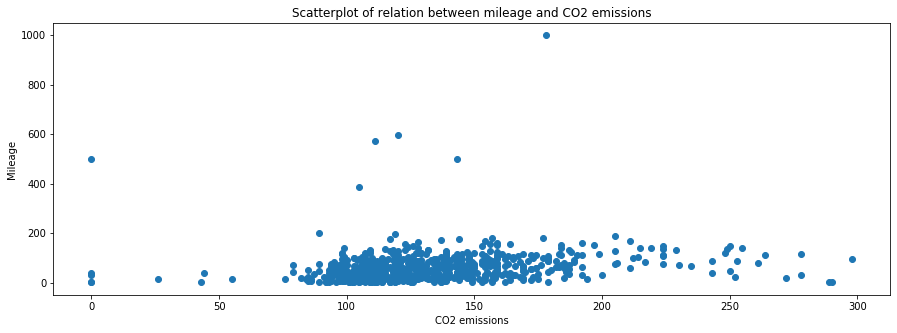

In [70]:
#Let's scatterplot the mileage and CO2 emissions
plt.figure(figsize=(15, 5))
plt.scatter(x=final_dataset['CO2 emissions(g/km)'], y=final_dataset['Mileage(miles)'])
plt.title('Scatterplot of relation between mileage and CO2 emissions')
plt.xlabel('CO2 emissions')
plt.ylabel('Mileage')
plt.show()

#Check how we can clear up the below clustered data  

In [37]:
#Brochure engine size
#Before googling the data, we need to check which rows of brochure engine size datas are missing from and which car it belongs to
# The four missing values for borchure are 
#2008 Toyota Hilux 3.0l Invincible ---> 3.0L
#2011 Volkswagen golf match TDI 1.6 105 PS HatchBack -->1.6L
#2021 Citroen C4 50kWh Shine Plus Auto 5dr HatchBack --Electric
#2021 Nissan Navara Brand new 2121 model Double hatchback-->2.3L

#Looks like some of the empty brochure size is of that of electric cars, so let's clean that aswell